In [95]:
# magic
%load_ext autoreload
%autoreload 2 
#any changes to the function files will be updated on every run
#%pdb 1 
#where code fails, stops at that breakpoint and allows to examine potential error
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
#import numdifftools as nd
import pandas as pd
#import pymc3 as pm

from tqdm import tqdm
from sklearn import preprocessing
from numpy.linalg import multi_dot
import scipy
from scipy import stats
from scipy.stats import invgamma
from scipy.special import gamma
from scipy.special import digamma
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import levy_stable
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

In [97]:
from numba import vectorize, float64, guvectorize, jit

In [98]:
np.random.seed(6898)

In [99]:
from functions.f_mean_adjust_ss import (alpha_stable, alpha_stable_ss, summary_statistics, mean_adjustment_summary_statistics)

## LOAD DATASET

In [100]:
actual_data = alpha_stable(1.5, 0.5, 1, 0, 200, 1)
actual_data

array([[-1.50282924e+00, -1.95421636e+00,  2.10207693e+00,
         2.36601456e+00,  1.71007212e+00,  1.44099855e+00,
         4.47711735e-01, -6.98607324e-01, -1.07866410e+00,
        -1.13015917e+00, -8.28693943e-01,  3.37776897e-01,
        -2.02486182e-01, -3.77939084e-01, -9.09473492e-01,
        -3.90454468e-01, -8.95412966e-01,  8.67519223e-01,
        -1.11068169e+00,  1.55610269e+00,  3.69635897e+00,
         1.65643209e-01, -7.66534565e-01,  2.12991763e+00,
         9.30086181e-03,  9.86590704e-01, -3.88093939e-01,
        -7.30954061e-01, -1.08915568e+00,  6.04251681e+00,
        -2.85944721e-01,  1.85793772e+00, -2.29542287e-01,
         5.65633745e-01, -2.65675995e+00, -2.89848272e+01,
         3.44892790e-01,  7.08196629e+00, -4.13803589e+00,
        -2.36513270e+00,  3.87427868e-01,  1.70999074e+01,
        -2.37239951e+00, -2.39794542e+00,  2.77993625e-01,
        -1.39037152e+00, -1.58714974e+00, -1.41748564e+00,
        -6.24560932e-01, -1.01606208e+00, -7.87606471e-0

In [101]:
actual_summary_statistics = alpha_stable_ss(actual_data)
actual_summary_statistics

array([1.31579486, 0.53882575, 0.92807094, 0.43969548])

In [102]:
# Using previously simulated data for consistency
actual_summary_statistics = np.array([ 1.36495524,  0.27388675,  0.78684313, -0.08169088])

In [103]:
num_coeffs = np.shape(actual_summary_statistics)[0]
num_latent = np.shape(actual_summary_statistics)[0]
num_datasets = 200
n_samples = 200
gamma_samples = 20

In [104]:
from multiprocessing import Pool
from functools import partial
pool = Pool(8)

## FIND THE BEST THETA (COEFFICIENTS) USING VB

In [105]:
# Functions must be imported for multiprocessing to work
from functions.f_gradient_lb_mean_nuissance import (fun_gradient_lb)

In [106]:
theta = np.array([1.5, 0.5, 1, 0])

In [107]:
ss = summary_statistics(theta, n_samples, num_datasets)
ss

(array([1.51959246, 0.64342034, 0.98202946, 0.06916311]),
 array([[ 0.02319986,  0.03471395,  0.00718395, -0.02307773],
        [ 0.03471395,  0.16385624,  0.01382983,  0.02597644],
        [ 0.00718395,  0.01382983,  0.00820386, -0.00146655],
        [-0.02307773,  0.02597644, -0.00146655,  0.08581748]]))

In [108]:
diff_mean = actual_summary_statistics - ss[0]
diff_mean.T @ np.linalg.inv(ss[1]) @ np.diag(ss[1])

-0.44919151196911467

In [109]:
mean_nuissance_p1 = np.linalg.inv(np.identity(num_latent) / 1 + np.diag(ss[1]).T @ np.linalg.inv(ss[1]) @ np.diag(ss[1]))
diag_var = np.zeros((num_coeffs, num_coeffs))
np.fill_diagonal(diag_var, np.diag(ss[1])) 
mean_nuissance_p2 = diag_var @ np.linalg.inv(ss[1]) @ diff_mean
mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2
mean_nuissance

array([-0.12822346,  0.37444055, -0.118468  , -0.35975365])

In [110]:
variance_nuissance = np.linalg.inv(np.identity(num_latent)) / 10 + np.diag(ss[1]).T @ np.linalg.inv(ss[1]) @ np.diag(ss[1])
variance_nuissance

array([[0.33403308, 0.23403308, 0.23403308, 0.23403308],
       [0.23403308, 0.33403308, 0.23403308, 0.23403308],
       [0.23403308, 0.23403308, 0.33403308, 0.23403308],
       [0.23403308, 0.23403308, 0.23403308, 0.33403308]])

In [111]:
Gamma = multivariate_normal.rvs(mean = mean_nuissance, cov = variance_nuissance)
adjusted_theta_q = np.concatenate((theta, Gamma))
adjusted_theta_q

array([ 1.5       ,  0.5       ,  1.        ,  0.        , -0.20087464,
        0.41318776, -0.26001232, -0.22389407])

In [112]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 200 # number of datasets
        self.num_coeffs = np.shape(actual_summary_statistics)[0] # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = np.array([np.log((1.5-1.1)/(2-1.5)),np.log((0.5+1)/(1-0.5)),np.log(1),0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                theta_0_samples = multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)

                # Multiprocessing a function with several inputs
                results = pool.map(partial(fun_gradient_lb, theta_samples = theta_0_samples, mu_q = mu_0, l_q = l_0, c = 0, n_samples = n_samples, n_datasets= num_datasets, num_coeffs = self.num_coeffs, num_latent = num_latent, actual_summary_statistics = actual_summary_statistics), np.arange(self.samples)) 
                results = np.reshape(results, (self.samples, self.num_coeffs))
                Gradient_lb_init = results[:,0]
                lb_0 = results[:,1]
                Flattened_gradient_lb = results[:,2]
                Flattened_gradient_log_q = results[:,3]

                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)

                theta_q_samples = multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)

                # Multiprocessing a function with several inputs
                results = pool.map(partial(fun_gradient_lb, theta_samples = theta_q_samples, mu_q = mu_q, l_q = l_q, c = c, n_samples = n_samples, n_datasets= num_datasets, num_coeffs = self.num_coeffs, num_latent = num_latent, actual_summary_statistics = actual_summary_statistics), np.arange(self.samples)) 
                results = np.reshape(results, (self.samples, self.num_coeffs))
                Gradient_lb = results[:,0]
                lb_t = results[:,1]
                Flattened_gradient_lb = results[:,2]
                Flattened_gradient_log_q = results[:,3]

                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)

                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

## RUN VB AND PRINT OUT VARIATIONAL PARAMS

In [113]:
# Set hyperparameters
stop = 5000

In [114]:
vb = GVB(400, actual_summary_statistics, 0.005, 2500, 100, 0.9, 0.9, 100, 100)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|          | 0/5000 [00:00<?, ?it/s]/anaconda3/envs/myenv/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
  0%|          | 1/5000 [00:20<28:41:01, 20.66s/it]

LB -21.43564343466539


  0%|          | 2/5000 [00:40<28:12:20, 20.32s/it]

LB -24.56563113428722


  0%|          | 3/5000 [01:00<27:48:34, 20.04s/it]

LB -23.273660368953063


  0%|          | 4/5000 [01:22<28:55:07, 20.84s/it]

LB -24.017996522903157


  0%|          | 5/5000 [01:42<28:37:16, 20.63s/it]

LB -21.441009599855985


  0%|          | 6/5000 [02:03<28:45:53, 20.74s/it]

LB -21.777707330164265


  0%|          | 7/5000 [02:23<28:13:10, 20.35s/it]

LB -23.394964870257077


  0%|          | 8/5000 [02:43<28:05:54, 20.26s/it]

LB -22.88866767175768


  0%|          | 9/5000 [03:04<28:18:07, 20.41s/it]

LB -20.783063532463725


  0%|          | 10/5000 [03:26<29:17:33, 21.13s/it]

LB -20.90803994247527


  0%|          | 11/5000 [03:46<28:51:39, 20.83s/it]

LB -22.38546585205337


  0%|          | 12/5000 [04:07<28:43:38, 20.73s/it]

LB -21.018117965315763


  0%|          | 13/5000 [04:27<28:27:22, 20.54s/it]

LB -20.986590553408547


  0%|          | 14/5000 [04:48<28:33:27, 20.62s/it]

LB -22.131697654811365


  0%|          | 15/5000 [05:08<28:27:23, 20.55s/it]

LB -20.12344972612872


  0%|          | 16/5000 [05:31<29:10:02, 21.07s/it]

LB -19.95603367873418


  0%|          | 17/5000 [05:52<29:13:12, 21.11s/it]

LB -20.375956311312375


  0%|          | 18/5000 [06:14<29:48:19, 21.54s/it]

LB -22.77413106152161


  0%|          | 19/5000 [06:36<29:56:30, 21.64s/it]

LB -21.826221073861213


  0%|          | 20/5000 [07:01<31:21:00, 22.66s/it]

LB -21.027175940992326


  0%|          | 21/5000 [07:25<31:42:26, 22.93s/it]

LB -21.512540576516198


  0%|          | 22/5000 [07:49<32:25:41, 23.45s/it]

LB -20.63804383131199


  0%|          | 23/5000 [08:10<31:21:06, 22.68s/it]

LB -20.78487948484616


  0%|          | 24/5000 [08:33<31:24:14, 22.72s/it]

LB -21.39359921139173


  0%|          | 25/5000 [08:52<29:49:49, 21.59s/it]

LB -19.993093546915848


  1%|          | 26/5000 [09:13<29:24:11, 21.28s/it]

LB -20.63263059705551


  1%|          | 27/5000 [09:32<28:37:42, 20.72s/it]

LB -18.663599202132946


  1%|          | 28/5000 [09:56<30:02:14, 21.75s/it]

LB -19.61983270285011


  1%|          | 29/5000 [10:16<29:05:44, 21.07s/it]

LB -21.504092785939676


  1%|          | 30/5000 [10:34<28:08:27, 20.38s/it]

LB -18.905954303121185


  1%|          | 31/5000 [10:53<27:20:06, 19.80s/it]

LB -19.982200041101024


  1%|          | 32/5000 [11:08<25:29:18, 18.47s/it]

LB -19.41517292644633


  1%|          | 33/5000 [11:26<25:06:47, 18.20s/it]

LB -18.6171064668264


  1%|          | 34/5000 [11:44<24:55:51, 18.07s/it]

LB -21.408179571746604


  1%|          | 35/5000 [12:02<24:52:56, 18.04s/it]

LB -19.2575410472957


  1%|          | 36/5000 [12:20<25:11:26, 18.27s/it]

LB -20.485983406649584


  1%|          | 37/5000 [12:41<26:01:00, 18.87s/it]

LB -19.788956769287797


  1%|          | 38/5000 [13:01<26:42:23, 19.38s/it]

LB -19.279875679556547


  1%|          | 39/5000 [13:21<26:59:29, 19.59s/it]

LB -20.87759529731959


  1%|          | 40/5000 [13:40<26:44:31, 19.41s/it]

LB -19.090611207168674


  1%|          | 41/5000 [13:59<26:27:58, 19.21s/it]

LB -19.677835462785033


  1%|          | 42/5000 [14:16<25:33:28, 18.56s/it]

LB -18.700770694217454


  1%|          | 43/5000 [14:34<25:07:57, 18.25s/it]

LB -19.360465141880482


  1%|          | 44/5000 [1:04:51<1263:39:20, 917.91s/it]

LB -19.44332287907562


  1%|          | 45/5000 [1:05:14<894:02:47, 649.56s/it] 

LB -18.285629157589362


  1%|          | 46/5000 [1:05:40<636:29:41, 462.53s/it]

LB -17.209472075731107


  1%|          | 47/5000 [1:06:03<454:58:57, 330.70s/it]

LB -19.89619765106802


  1%|          | 48/5000 [1:06:29<328:56:20, 239.13s/it]

LB -18.83269437506732


  1%|          | 49/5000 [1:06:55<241:11:50, 175.38s/it]

LB -19.14052935554556


  1%|          | 50/5000 [1:07:18<177:58:54, 129.44s/it]

LB -16.762280614260455


  1%|          | 51/5000 [1:07:39<133:09:05, 96.86s/it] 

LB -16.967790931317335


  1%|          | 52/5000 [1:08:00<102:11:37, 74.35s/it]

LB -18.675203576866355


  1%|          | 53/5000 [1:08:24<81:08:48, 59.05s/it] 

LB -18.408615171302923


  1%|          | 54/5000 [1:08:46<65:53:28, 47.96s/it]

LB -16.78685077825811


  1%|          | 55/5000 [1:09:09<55:44:28, 40.58s/it]

LB -18.417939401925494


  1%|          | 56/5000 [1:09:31<48:01:19, 34.97s/it]

LB -19.791991834529775


  1%|          | 57/5000 [1:09:55<43:17:58, 31.54s/it]

LB -17.37825115357063


  1%|          | 58/5000 [1:10:17<39:28:50, 28.76s/it]

LB -17.990459201184553


  1%|          | 59/5000 [1:10:39<36:44:58, 26.78s/it]

LB -18.569492536515877


  1%|          | 60/5000 [1:11:03<35:45:48, 26.06s/it]

LB -16.99393148595851


  1%|          | 61/5000 [1:11:23<33:06:22, 24.13s/it]

LB -17.088396219073243


  1%|          | 62/5000 [1:11:45<32:01:18, 23.35s/it]

LB -18.198414599315637


  1%|▏         | 63/5000 [1:12:06<31:26:34, 22.93s/it]

LB -17.989980846733285


  1%|▏         | 64/5000 [1:12:30<31:42:34, 23.13s/it]

LB -18.51311522158043


  1%|▏         | 65/5000 [1:12:58<33:30:54, 24.45s/it]

LB -17.91444342742569


  1%|▏         | 66/5000 [1:13:26<35:04:14, 25.59s/it]

LB -18.595316814321624


  1%|▏         | 67/5000 [1:13:50<34:31:53, 25.20s/it]

LB -17.888723924121134


  1%|▏         | 68/5000 [1:14:13<33:41:47, 24.60s/it]

LB -17.93605107665337


  1%|▏         | 69/5000 [1:14:36<33:04:20, 24.15s/it]

LB -17.862954343796222


  1%|▏         | 70/5000 [1:14:58<32:09:44, 23.49s/it]

LB -17.685498139290754


  1%|▏         | 71/5000 [1:15:20<31:13:33, 22.81s/it]

LB -16.09772322048012


  1%|▏         | 72/5000 [1:15:42<31:13:29, 22.81s/it]

LB -17.826734138391238


  1%|▏         | 73/5000 [1:16:05<31:14:05, 22.82s/it]

LB -17.902143534688097


  1%|▏         | 74/5000 [1:16:29<31:42:15, 23.17s/it]

LB -17.56546425337481


  2%|▏         | 75/5000 [1:16:52<31:41:25, 23.16s/it]

LB -17.70902112045002


  2%|▏         | 76/5000 [1:17:16<31:44:10, 23.20s/it]

LB -17.936029057579685


  2%|▏         | 77/5000 [1:17:38<31:33:35, 23.08s/it]

LB -17.500281357229074


  2%|▏         | 78/5000 [1:18:03<31:59:25, 23.40s/it]

LB -16.95490907765074


  2%|▏         | 79/5000 [1:18:25<31:27:35, 23.01s/it]

LB -17.45568203547023


  2%|▏         | 80/5000 [1:18:47<31:01:36, 22.70s/it]

LB -17.646087849489334


  2%|▏         | 81/5000 [1:19:10<31:05:32, 22.76s/it]

LB -17.35546667112985


  2%|▏         | 82/5000 [1:19:33<31:23:04, 22.97s/it]

LB -17.490026812451507


  2%|▏         | 83/5000 [1:19:56<31:31:03, 23.08s/it]

LB -18.321891585573823


  2%|▏         | 84/5000 [1:20:18<30:54:01, 22.63s/it]

LB -17.65080102149839


  2%|▏         | 85/5000 [1:20:42<31:28:33, 23.05s/it]

LB -17.51694432584433


  2%|▏         | 86/5000 [1:21:04<31:00:05, 22.71s/it]

LB -17.15086730191613


  2%|▏         | 87/5000 [1:21:26<30:38:00, 22.45s/it]

LB -16.193950291116742


  2%|▏         | 88/5000 [1:21:48<30:29:50, 22.35s/it]

LB -16.196679325127217


  2%|▏         | 89/5000 [1:22:09<30:05:20, 22.06s/it]

LB -16.057098068680766


  2%|▏         | 90/5000 [1:22:30<29:44:09, 21.80s/it]

LB -15.568919897791636


  2%|▏         | 91/5000 [1:22:52<29:32:21, 21.66s/it]

LB -15.99590719767932


  2%|▏         | 92/5000 [1:23:14<29:52:27, 21.91s/it]

LB -15.973911634736309


  2%|▏         | 93/5000 [1:23:38<30:40:52, 22.51s/it]

LB -17.054025428880355


  2%|▏         | 94/5000 [1:24:00<30:27:23, 22.35s/it]

LB -16.967726167121135


  2%|▏         | 95/5000 [1:24:22<30:22:20, 22.29s/it]

LB -17.099857751390974


  2%|▏         | 96/5000 [1:24:45<30:34:38, 22.45s/it]

LB -18.03695914449617


  2%|▏         | 97/5000 [1:25:08<30:37:40, 22.49s/it]

LB -17.525273312326185


  2%|▏         | 98/5000 [1:25:29<29:59:58, 22.03s/it]

LB -17.538557296902347


  2%|▏         | 99/5000 [1:25:50<29:52:07, 21.94s/it]

LB -16.968324785537234


  2%|▏         | 100/5000 [1:26:12<29:38:27, 21.78s/it]

LB -17.58594628249938


  2%|▏         | 101/5000 [1:26:34<29:54:37, 21.98s/it]

LB Smoothed -18.982958560456577


  2%|▏         | 102/5000 [1:26:58<30:31:33, 22.44s/it]

LB Smoothed -18.902259969526128


  2%|▏         | 103/5000 [1:27:21<31:01:27, 22.81s/it]

LB Smoothed -18.830932030848697


  2%|▏         | 104/5000 [1:27:45<31:10:31, 22.92s/it]

LB Smoothed -18.759788552650075


  2%|▏         | 105/5000 [1:28:08<31:25:29, 23.11s/it]

LB Smoothed -18.72388083481117


  2%|▏         | 106/5000 [1:28:31<31:18:17, 23.03s/it]

LB Smoothed -18.67421627494836


  2%|▏         | 107/5000 [1:28:55<31:52:28, 23.45s/it]

LB Smoothed -18.59951795800117


  2%|▏         | 108/5000 [1:29:18<31:33:55, 23.23s/it]

LB Smoothed -18.532382693145756


  2%|▏         | 109/5000 [1:29:40<31:01:14, 22.83s/it]

LB Smoothed -18.488550934085527


  2%|▏         | 110/5000 [1:30:01<30:23:17, 22.37s/it]

LB Smoothed -18.44350932346859


  2%|▏         | 111/5000 [1:30:24<30:40:52, 22.59s/it]

LB Smoothed -18.395695390086015


  2%|▏         | 112/5000 [1:30:47<30:44:12, 22.64s/it]

LB Smoothed -18.354281622746907


  2%|▏         | 113/5000 [1:31:10<30:55:32, 22.78s/it]

LB Smoothed -18.309537820019358


  2%|▏         | 114/5000 [1:31:34<31:11:01, 22.98s/it]

LB Smoothed -18.24696103326624


  2%|▏         | 115/5000 [1:31:57<31:22:45, 23.12s/it]

LB Smoothed -18.205120799179177


  2%|▏         | 116/5000 [1:32:21<31:28:50, 23.20s/it]

LB Smoothed -18.173971398398002


  2%|▏         | 117/5000 [1:32:44<31:35:02, 23.29s/it]

LB Smoothed -18.137930946474636


  2%|▏         | 118/5000 [1:33:05<30:38:52, 22.60s/it]

LB Smoothed -18.07368992700356


  2%|▏         | 119/5000 [1:33:27<30:23:12, 22.41s/it]

LB Smoothed -18.01927132807279


  2%|▏         | 120/5000 [1:33:47<29:32:16, 21.79s/it]

LB Smoothed -17.968573190355777


  2%|▏         | 121/5000 [1:34:11<30:03:45, 22.18s/it]

LB Smoothed -17.911562309220894


  2%|▏         | 122/5000 [1:34:33<30:16:33, 22.34s/it]

LB Smoothed -17.857789291021813


  2%|▏         | 123/5000 [1:34:56<30:38:05, 22.61s/it]

LB Smoothed -17.805989318196456


  2%|▏         | 124/5000 [1:35:20<31:06:30, 22.97s/it]

LB Smoothed -17.754142299076474


  2%|▎         | 125/5000 [1:35:43<30:59:36, 22.89s/it]

LB Smoothed -17.718793461443674


  3%|▎         | 126/5000 [1:36:06<31:10:40, 23.03s/it]

LB Smoothed -17.66944461844965


  3%|▎         | 127/5000 [1:36:28<30:40:11, 22.66s/it]

LB Smoothed -17.647653606757675


  3%|▎         | 128/5000 [1:36:50<30:23:55, 22.46s/it]

LB Smoothed -17.61168795042503


  3%|▎         | 129/5000 [1:37:10<29:29:22, 21.79s/it]

LB Smoothed -17.563334062533368


  3%|▎         | 130/5000 [1:37:32<29:32:23, 21.84s/it]

LB Smoothed -17.538598800228257


  3%|▎         | 131/5000 [1:37:55<29:54:42, 22.12s/it]

LB Smoothed -17.50119941366177


  3%|▎         | 132/5000 [1:38:18<30:20:17, 22.44s/it]

LB Smoothed -17.47349621769722


  3%|▎         | 133/5000 [1:38:42<30:52:05, 22.83s/it]

LB Smoothed -17.448055356180642


  3%|▎         | 134/5000 [1:39:06<31:19:16, 23.17s/it]

LB Smoothed -17.393752117550473


  3%|▎         | 135/5000 [1:39:30<31:41:31, 23.45s/it]

LB Smoothed -17.362649224213467


  3%|▎         | 136/5000 [1:39:53<31:26:50, 23.28s/it]

LB Smoothed -17.31909563680316


  3%|▎         | 137/5000 [1:40:15<30:58:51, 22.93s/it]

LB Smoothed -17.286491378359433


  3%|▎         | 138/5000 [1:40:36<30:12:27, 22.37s/it]

LB Smoothed -17.261801888352686


  3%|▎         | 139/5000 [1:40:57<29:40:10, 21.97s/it]

LB Smoothed -17.207325094275635


  3%|▎         | 140/5000 [1:41:22<30:41:27, 22.73s/it]

LB Smoothed -17.175746040855852


  3%|▎         | 141/5000 [1:41:45<30:58:42, 22.95s/it]

LB Smoothed -17.1267259264761


  3%|▎         | 142/5000 [1:42:09<31:26:04, 23.29s/it]

LB Smoothed -17.095411055703966


  3%|▎         | 143/5000 [1:42:32<31:14:08, 23.15s/it]

LB Smoothed -17.058369175162913


  3%|▎         | 144/5000 [1:42:56<31:22:16, 23.26s/it]

LB Smoothed -17.01450787881019


  3%|▎         | 145/5000 [1:43:19<31:25:54, 23.31s/it]

LB Smoothed -16.982716088492396


  3%|▎         | 146/5000 [1:43:43<31:32:15, 23.39s/it]

LB Smoothed -16.969908366177705


  3%|▎         | 147/5000 [1:44:05<31:09:05, 23.11s/it]

LB Smoothed -16.927859600682382


  3%|▎         | 148/5000 [1:44:27<30:30:07, 22.63s/it]

LB Smoothed -16.89408651969831


  3%|▎         | 149/5000 [1:44:48<29:52:56, 22.18s/it]

LB Smoothed -16.86435003155142


  3%|▎         | 150/5000 [1:45:11<30:23:41, 22.56s/it]

LB Smoothed -16.856550117385662


  3%|▎         | 151/5000 [1:45:33<30:02:38, 22.31s/it]

LB Smoothed -16.845097829212634


  3%|▎         | 152/5000 [1:45:56<30:23:53, 22.57s/it]

LB Smoothed -16.813892868135213


  3%|▎         | 153/5000 [1:46:19<30:40:25, 22.78s/it]

LB Smoothed -16.781510015642894


  3%|▎         | 154/5000 [1:46:41<30:17:35, 22.50s/it]

LB Smoothed -16.765418887398123


  3%|▎         | 155/5000 [1:47:04<30:16:10, 22.49s/it]

LB Smoothed -16.734807828224497


  3%|▎         | 156/5000 [1:47:26<30:17:38, 22.51s/it]

LB Smoothed -16.689087216064838


  3%|▎         | 157/5000 [1:47:48<30:09:24, 22.42s/it]

LB Smoothed -16.666897192965095


  3%|▎         | 158/5000 [1:48:09<29:26:11, 21.89s/it]

LB Smoothed -16.636524130431685


  3%|▎         | 159/5000 [1:48:30<29:15:04, 21.75s/it]

LB Smoothed -16.605348590797785


  3%|▎         | 160/5000 [1:48:53<29:37:30, 22.04s/it]

LB Smoothed -16.585801534063883


  3%|▎         | 161/5000 [1:49:16<29:47:20, 22.16s/it]

LB Smoothed -16.56583923660442


  3%|▎         | 162/5000 [1:49:38<29:43:42, 22.12s/it]

LB Smoothed -16.535845130503454


  3%|▎         | 163/5000 [1:50:01<30:04:22, 22.38s/it]

LB Smoothed -16.50960399639185


  3%|▎         | 164/5000 [1:50:24<30:17:37, 22.55s/it]

LB Smoothed -16.476146160958983


  3%|▎         | 165/5000 [1:50:46<30:11:27, 22.48s/it]

LB Smoothed -16.45042105677276


  3%|▎         | 166/5000 [1:51:09<30:15:59, 22.54s/it]

LB Smoothed -16.414701299064372


  3%|▎         | 167/5000 [1:51:30<29:43:23, 22.14s/it]

LB Smoothed -16.389639733867902


  3%|▎         | 168/5000 [1:51:51<29:23:33, 21.90s/it]

LB Smoothed -16.362748661836143


  3%|▎         | 169/5000 [1:52:14<29:42:59, 22.14s/it]

LB Smoothed -16.330093842087713


  3%|▎         | 170/5000 [1:52:37<30:07:44, 22.46s/it]

LB Smoothed -16.301613200378544


  3%|▎         | 171/5000 [1:53:01<30:46:10, 22.94s/it]

LB Smoothed -16.298381640283843


  3%|▎         | 172/5000 [1:53:25<31:05:47, 23.19s/it]

LB Smoothed -16.27327925567994


  3%|▎         | 173/5000 [1:53:48<30:59:10, 23.11s/it]

LB Smoothed -16.244742393286238


  3%|▎         | 174/5000 [1:54:11<31:09:56, 23.25s/it]

LB Smoothed -16.213372390406043


  4%|▎         | 175/5000 [1:54:36<31:33:33, 23.55s/it]

LB Smoothed -16.178132410715882


  4%|▎         | 176/5000 [1:54:58<31:02:48, 23.17s/it]

LB Smoothed -16.14441506743828


  4%|▎         | 177/5000 [1:55:20<30:28:58, 22.75s/it]

LB Smoothed -16.11012704964028


  4%|▎         | 178/5000 [1:55:40<29:42:19, 22.18s/it]

LB Smoothed -16.085953447309237


  4%|▎         | 179/5000 [1:56:04<30:22:23, 22.68s/it]

LB Smoothed -16.058231194664952


  4%|▎         | 180/5000 [1:56:28<30:35:47, 22.85s/it]

LB Smoothed -16.026170785284886


  4%|▎         | 181/5000 [1:56:51<30:49:21, 23.03s/it]

LB Smoothed -16.00116648518799


  4%|▎         | 182/5000 [1:57:15<31:08:29, 23.27s/it]

LB Smoothed -15.979450103140747


  4%|▎         | 183/5000 [1:57:38<31:09:28, 23.29s/it]

LB Smoothed -15.94656908621116


  4%|▎         | 184/5000 [1:58:01<31:00:32, 23.18s/it]

LB Smoothed -15.9191114244762


  4%|▎         | 185/5000 [1:58:24<31:01:09, 23.19s/it]

LB Smoothed -15.893898776485983


  4%|▎         | 186/5000 [1:58:47<30:36:10, 22.89s/it]

LB Smoothed -15.875458419155281


  4%|▎         | 187/5000 [1:59:07<29:36:43, 22.15s/it]

LB Smoothed -15.863173297397521


  4%|▍         | 188/5000 [1:59:28<29:07:44, 21.79s/it]

LB Smoothed -15.846204258816252


  4%|▍         | 189/5000 [1:59:50<29:11:52, 21.85s/it]

LB Smoothed -15.831080128959455


  4%|▍         | 190/5000 [2:00:14<30:02:04, 22.48s/it]

LB Smoothed -15.818019232843247


  4%|▍         | 191/5000 [2:00:36<30:01:15, 22.47s/it]

LB Smoothed -15.804094290245546


  4%|▍         | 192/5000 [2:00:59<30:09:31, 22.58s/it]

LB Smoothed -15.796590002726356


  4%|▍         | 193/5000 [2:01:23<30:38:12, 22.94s/it]

LB Smoothed -15.773571346367367


  4%|▍         | 194/5000 [2:01:45<30:10:21, 22.60s/it]

LB Smoothed -15.751360395616663


  4%|▍         | 195/5000 [2:02:07<29:57:06, 22.44s/it]

LB Smoothed -15.727014684193733


  4%|▍         | 196/5000 [2:02:28<29:17:48, 21.95s/it]

LB Smoothed -15.689634425310437


  4%|▍         | 197/5000 [2:02:50<29:20:43, 22.00s/it]

LB Smoothed -15.662902962011247


  4%|▍         | 198/5000 [2:03:11<28:52:13, 21.64s/it]

LB Smoothed -15.632928990741416


  4%|▍         | 199/5000 [2:03:33<29:09:24, 21.86s/it]

LB Smoothed -15.611250105822148


  4%|▍         | 200/5000 [2:03:56<29:37:09, 22.21s/it]

LB Smoothed -15.582087185262145


  4%|▍         | 201/5000 [2:04:21<30:34:25, 22.93s/it]

LB Smoothed -15.565152813550663


  4%|▍         | 202/5000 [2:04:44<30:43:24, 23.05s/it]

LB Smoothed -15.548560930045872


  4%|▍         | 203/5000 [2:05:07<30:56:12, 23.22s/it]

LB Smoothed -15.52387420247614


  4%|▍         | 204/5000 [2:05:31<31:10:01, 23.39s/it]

LB Smoothed -15.491536477165646


  4%|▍         | 205/5000 [2:05:54<31:04:17, 23.33s/it]

LB Smoothed -15.474754799385678


  4%|▍         | 206/5000 [2:06:16<30:27:20, 22.87s/it]

LB Smoothed -15.458145737000553


  4%|▍         | 207/5000 [2:06:37<29:37:54, 22.26s/it]

LB Smoothed -15.441469625351877


  4%|▍         | 208/5000 [2:07:03<30:57:52, 23.26s/it]

LB Smoothed -15.415536016104161


  4%|▍         | 209/5000 [2:07:26<30:51:12, 23.18s/it]

LB Smoothed -15.395336550705053


  4%|▍         | 210/5000 [2:07:49<30:58:07, 23.28s/it]

LB Smoothed -15.36408442744497


  4%|▍         | 211/5000 [2:08:13<31:11:54, 23.45s/it]

LB Smoothed -15.337153496131112


  4%|▍         | 212/5000 [2:08:36<31:00:41, 23.32s/it]

LB Smoothed -15.316253581965777


  4%|▍         | 213/5000 [2:08:59<31:00:29, 23.32s/it]

LB Smoothed -15.299526411747218


  4%|▍         | 214/5000 [2:09:24<31:32:14, 23.72s/it]

LB Smoothed -15.28102252067266


  4%|▍         | 215/5000 [2:09:47<31:16:23, 23.53s/it]

LB Smoothed -15.252250802081921


  4%|▍         | 216/5000 [2:10:09<30:26:00, 22.90s/it]

LB Smoothed -15.233621995549225


  4%|▍         | 217/5000 [2:10:29<29:23:38, 22.12s/it]

LB Smoothed -15.21153928612237


  4%|▍         | 218/5000 [2:10:51<29:32:56, 22.25s/it]

LB Smoothed -15.190773772716595


  4%|▍         | 219/5000 [2:11:16<30:29:05, 22.95s/it]

LB Smoothed -15.175482624898542


  4%|▍         | 220/5000 [2:11:39<30:22:56, 22.88s/it]

LB Smoothed -15.159634092337022


  4%|▍         | 221/5000 [2:12:01<30:08:53, 22.71s/it]

LB Smoothed -15.150671629134216


  4%|▍         | 222/5000 [2:12:24<30:06:06, 22.68s/it]

LB Smoothed -15.13880496318872


  4%|▍         | 223/5000 [2:12:47<30:17:39, 22.83s/it]

LB Smoothed -15.117119219058567


  4%|▍         | 224/5000 [2:13:09<30:09:14, 22.73s/it]

LB Smoothed -15.097008261382015


  4%|▍         | 225/5000 [2:13:31<29:34:14, 22.29s/it]

LB Smoothed -15.083249853611923


  5%|▍         | 226/5000 [2:13:53<29:34:39, 22.30s/it]

LB Smoothed -15.060534349870036


  5%|▍         | 227/5000 [2:14:13<28:49:01, 21.74s/it]

LB Smoothed -15.045306931439045


  5%|▍         | 228/5000 [2:14:36<29:11:26, 22.02s/it]

LB Smoothed -15.021741595604075


  5%|▍         | 229/5000 [2:14:59<29:30:41, 22.27s/it]

LB Smoothed -14.99874740921436


  5%|▍         | 230/5000 [2:15:21<29:36:53, 22.35s/it]

LB Smoothed -14.985509097786538


  5%|▍         | 231/5000 [2:15:44<29:31:14, 22.28s/it]

LB Smoothed -14.967681686466129


  5%|▍         | 232/5000 [2:16:06<29:43:45, 22.45s/it]

LB Smoothed -14.950491683803955


  5%|▍         | 233/5000 [2:16:30<30:13:12, 22.82s/it]

LB Smoothed -14.938749417900636


  5%|▍         | 234/5000 [2:16:52<30:03:11, 22.70s/it]

LB Smoothed -14.92168494640696


  5%|▍         | 235/5000 [2:17:14<29:28:56, 22.27s/it]

LB Smoothed -14.901154776101796


  5%|▍         | 236/5000 [2:17:38<30:13:19, 22.84s/it]

LB Smoothed -14.883333933109428


  5%|▍         | 237/5000 [2:18:03<31:07:01, 23.52s/it]

LB Smoothed -14.859326324395186


  5%|▍         | 238/5000 [2:18:29<31:55:10, 24.13s/it]

LB Smoothed -14.8505529030596


  5%|▍         | 239/5000 [2:18:55<32:47:38, 24.80s/it]

LB Smoothed -14.838455821852769


  5%|▍         | 240/5000 [2:19:21<33:13:18, 25.13s/it]

LB Smoothed -14.834851140666617


  5%|▍         | 241/5000 [2:19:49<34:35:17, 26.16s/it]

LB Smoothed -14.817903005301671


  5%|▍         | 242/5000 [2:20:19<35:48:02, 27.09s/it]

LB Smoothed -14.802918466633844


  5%|▍         | 243/5000 [2:20:49<37:01:01, 28.01s/it]

LB Smoothed -14.796240124620013


  5%|▍         | 244/5000 [2:21:20<38:06:55, 28.85s/it]

LB Smoothed -14.788036552094008


  5%|▍         | 245/5000 [2:21:48<38:01:20, 28.79s/it]

LB Smoothed -14.772676731871552


  5%|▍         | 246/5000 [2:22:19<38:43:58, 29.33s/it]

LB Smoothed -14.758372405724248


  5%|▍         | 247/5000 [2:22:50<39:31:19, 29.93s/it]

LB Smoothed -14.742674280470574


  5%|▍         | 248/5000 [2:23:28<42:43:35, 32.37s/it]

LB Smoothed -14.722525952087468


  5%|▍         | 249/5000 [2:24:08<45:38:13, 34.58s/it]

LB Smoothed -14.704503592344734


  5%|▌         | 250/5000 [2:24:52<49:20:40, 37.40s/it]

LB Smoothed -14.69164609789923


  5%|▌         | 251/5000 [2:25:43<54:39:40, 41.44s/it]

LB Smoothed -14.678083098804736


  5%|▌         | 252/5000 [2:26:37<59:52:35, 45.40s/it]

LB Smoothed -14.66845923307115


  5%|▌         | 253/5000 [2:27:29<62:20:43, 47.28s/it]

LB Smoothed -14.668897081455558


  5%|▌         | 254/5000 [2:28:22<64:25:40, 48.87s/it]

LB Smoothed -14.655168658475482


  5%|▌         | 255/5000 [2:29:12<65:00:59, 49.33s/it]

LB Smoothed -14.648619726037763


  5%|▌         | 256/5000 [2:30:02<65:13:48, 49.50s/it]

LB Smoothed -14.641484792940103


  5%|▌         | 257/5000 [2:30:56<66:58:56, 50.84s/it]

LB Smoothed -14.630159436736607


  5%|▌         | 258/5000 [2:31:51<68:29:07, 51.99s/it]

LB Smoothed -14.613940905823345


  5%|▌         | 259/5000 [2:32:46<69:47:16, 52.99s/it]

LB Smoothed -14.60555775707248


  5%|▌         | 260/5000 [2:34:58<101:08:58, 76.82s/it]

LB Smoothed -14.59303358697378


  5%|▌         | 261/5000 [2:35:30<83:21:03, 63.32s/it] 

LB Smoothed -14.580359517071047


  5%|▌         | 262/5000 [2:36:04<71:51:11, 54.60s/it]

LB Smoothed -14.56695198768913


  5%|▌         | 263/5000 [2:36:33<61:38:07, 46.84s/it]

LB Smoothed -14.550487248500751


  5%|▌         | 264/5000 [2:36:59<53:09:27, 40.41s/it]

LB Smoothed -14.538248909159242


  5%|▌         | 265/5000 [2:37:24<47:20:21, 35.99s/it]

LB Smoothed -14.527326988219642


  5%|▌         | 266/5000 [2:37:46<41:51:04, 31.83s/it]

LB Smoothed -14.513788850728949


  5%|▌         | 267/5000 [2:38:13<39:43:45, 30.22s/it]

LB Smoothed -14.500637031131722


  5%|▌         | 268/5000 [2:38:38<37:32:55, 28.57s/it]

LB Smoothed -14.500796086624828


  5%|▌         | 269/5000 [2:38:58<34:26:44, 26.21s/it]

LB Smoothed -14.495621257014458


  5%|▌         | 270/5000 [2:39:18<31:51:58, 24.25s/it]

LB Smoothed -14.479054570977887


  5%|▌         | 271/5000 [2:39:38<30:19:17, 23.08s/it]

LB Smoothed -14.465808571323688


  5%|▌         | 272/5000 [2:39:57<28:45:53, 21.90s/it]

LB Smoothed -14.453108411205292


  5%|▌         | 273/5000 [2:40:17<28:00:15, 21.33s/it]

LB Smoothed -14.450592985471122


  5%|▌         | 274/5000 [2:40:36<26:52:09, 20.47s/it]

LB Smoothed -14.451344345753586


  6%|▌         | 275/5000 [2:40:54<25:52:12, 19.71s/it]

LB Smoothed -14.448206145362434


  6%|▌         | 276/5000 [2:41:12<25:24:42, 19.37s/it]

LB Smoothed -14.450554948216421


  6%|▌         | 277/5000 [2:41:32<25:22:46, 19.35s/it]

LB Smoothed -14.44617276207208


  6%|▌         | 278/5000 [2:41:52<25:33:04, 19.48s/it]

LB Smoothed -14.441412144692139


  6%|▌         | 279/5000 [2:42:12<25:45:17, 19.64s/it]

LB Smoothed -14.43476270194039


  6%|▌         | 280/5000 [2:42:32<25:59:23, 19.82s/it]

LB Smoothed -14.422711128410324


  6%|▌         | 281/5000 [2:42:51<25:44:39, 19.64s/it]

LB Smoothed -14.408565162115822


  6%|▌         | 282/5000 [2:43:11<25:52:52, 19.75s/it]

LB Smoothed -14.396425423540114


  6%|▌         | 283/5000 [2:43:31<25:54:27, 19.77s/it]

LB Smoothed -14.38956940842924


  6%|▌         | 284/5000 [2:43:49<25:09:11, 19.20s/it]

LB Smoothed -14.385375230168947


  6%|▌         | 285/5000 [2:44:06<24:30:58, 18.72s/it]

LB Smoothed -14.373394428738877


  6%|▌         | 286/5000 [2:44:25<24:37:03, 18.80s/it]

LB Smoothed -14.360543197344997


  6%|▌         | 287/5000 [2:44:45<25:05:12, 19.16s/it]

LB Smoothed -14.355910065785778


  6%|▌         | 288/5000 [2:45:05<25:11:00, 19.24s/it]

LB Smoothed -14.352715480004923


  6%|▌         | 289/5000 [2:45:25<25:27:32, 19.45s/it]

LB Smoothed -14.352473608998784


  6%|▌         | 290/5000 [2:45:44<25:24:56, 19.43s/it]

LB Smoothed -14.347404217399388


  6%|▌         | 291/5000 [2:46:04<25:39:32, 19.62s/it]

LB Smoothed -14.336004552409488


  6%|▌         | 292/5000 [2:46:23<25:28:33, 19.48s/it]

LB Smoothed -14.328862606549684


  6%|▌         | 293/5000 [2:46:42<25:14:35, 19.31s/it]

LB Smoothed -14.31968171938105


  6%|▌         | 294/5000 [2:47:00<24:49:25, 18.99s/it]

LB Smoothed -14.312392595344871


  6%|▌         | 295/5000 [2:47:18<24:26:02, 18.70s/it]

LB Smoothed -14.309537467838778


  6%|▌         | 296/5000 [2:47:38<24:46:05, 18.96s/it]

LB Smoothed -14.300056522801924


  6%|▌         | 297/5000 [2:47:57<24:46:33, 18.97s/it]

LB Smoothed -14.292263913531736


  6%|▌         | 298/5000 [2:48:16<24:58:44, 19.12s/it]

LB Smoothed -14.283132614316015


  6%|▌         | 299/5000 [2:48:38<25:50:38, 19.79s/it]

LB Smoothed -14.275636854733655


  6%|▌         | 300/5000 [2:49:00<26:53:22, 20.60s/it]

LB Smoothed -14.265348596916821


  6%|▌         | 301/5000 [2:49:23<27:42:54, 21.23s/it]

LB Smoothed -14.260944147459494


  6%|▌         | 302/5000 [2:49:44<27:45:34, 21.27s/it]

LB Smoothed -14.25681646642274


  6%|▌         | 303/5000 [2:50:05<27:32:35, 21.11s/it]

LB Smoothed -14.25045408786742


  6%|▌         | 304/5000 [2:50:26<27:34:16, 21.14s/it]

LB Smoothed -14.244165949067865


  6%|▌         | 305/5000 [2:50:46<26:52:18, 20.60s/it]

LB Smoothed -14.241755272515961


  6%|▌         | 306/5000 [2:51:07<27:04:31, 20.77s/it]

LB Smoothed -14.23725317993878


  6%|▌         | 307/5000 [2:51:28<27:15:14, 20.91s/it]

LB Smoothed -14.241230358239562


  6%|▌         | 308/5000 [2:51:50<27:36:20, 21.18s/it]

LB Smoothed -14.243563520135199


  6%|▌         | 309/5000 [2:52:12<27:54:52, 21.42s/it]

LB Smoothed -14.246723958335254


  6%|▌         | 310/5000 [2:52:34<28:10:38, 21.63s/it]

LB Smoothed -14.250839159461357


  6%|▌         | 311/5000 [2:52:55<27:54:03, 21.42s/it]

LB Smoothed -14.249437348347389


  6%|▌         | 312/5000 [2:53:18<28:32:26, 21.92s/it]

LB Smoothed -14.24946960073769


  6%|▋         | 313/5000 [2:53:38<27:53:02, 21.42s/it]

LB Smoothed -14.250413236205368


  6%|▋         | 314/5000 [2:53:58<27:19:35, 20.99s/it]

LB Smoothed -14.25412937880684


  6%|▋         | 315/5000 [2:54:18<26:53:32, 20.66s/it]

LB Smoothed -14.24147650039895


  6%|▋         | 316/5000 [2:54:40<27:28:26, 21.12s/it]

LB Smoothed -14.240292846415537


  6%|▋         | 317/5000 [2:55:02<27:42:42, 21.30s/it]

LB Smoothed -14.236886921574804


  6%|▋         | 318/5000 [2:55:24<27:48:15, 21.38s/it]

LB Smoothed -14.238438904759278


  6%|▋         | 319/5000 [2:55:45<27:42:26, 21.31s/it]

LB Smoothed -14.238688108541652


  6%|▋         | 320/5000 [2:56:08<28:27:26, 21.89s/it]

LB Smoothed -14.229582262072379


  6%|▋         | 321/5000 [2:56:29<28:12:57, 21.71s/it]

LB Smoothed -14.224629842759455


  6%|▋         | 322/5000 [2:56:51<28:06:50, 21.64s/it]

LB Smoothed -14.225531768623327


  6%|▋         | 323/5000 [2:57:11<27:32:28, 21.20s/it]

LB Smoothed -14.21940342585033


  6%|▋         | 324/5000 [2:57:32<27:24:16, 21.10s/it]

LB Smoothed -14.220234291936238


  6%|▋         | 325/5000 [2:57:52<27:09:40, 20.92s/it]

LB Smoothed -14.21313897399661


  7%|▋         | 326/5000 [2:58:14<27:32:34, 21.21s/it]

LB Smoothed -14.212183188183038


  7%|▋         | 327/5000 [2:58:36<27:39:34, 21.31s/it]

LB Smoothed -14.209949493546002


  7%|▋         | 328/5000 [2:58:58<28:11:32, 21.72s/it]

LB Smoothed -14.208174754008695


  7%|▋         | 329/5000 [2:59:20<28:19:48, 21.83s/it]

LB Smoothed -14.199456083283408


  7%|▋         | 330/5000 [2:59:43<28:30:05, 21.97s/it]

LB Smoothed -14.196134058452524


  7%|▋         | 331/5000 [3:00:04<28:20:21, 21.85s/it]

LB Smoothed -14.192419487986147


  7%|▋         | 332/5000 [3:00:27<28:30:35, 21.99s/it]

LB Smoothed -14.185108710500879


  7%|▋         | 333/5000 [3:00:47<27:57:04, 21.56s/it]

LB Smoothed -14.187255599995728


  7%|▋         | 334/5000 [3:01:07<27:14:04, 21.01s/it]

LB Smoothed -14.184876740327175


  7%|▋         | 335/5000 [3:01:29<27:40:00, 21.35s/it]

LB Smoothed -14.176690724138236


  7%|▋         | 336/5000 [3:01:51<27:59:14, 21.60s/it]

LB Smoothed -14.171190590925379


  7%|▋         | 337/5000 [3:02:12<27:46:30, 21.44s/it]

LB Smoothed -14.165577580833206


  7%|▋         | 338/5000 [3:02:34<28:01:24, 21.64s/it]

LB Smoothed -14.150938750323427


  7%|▋         | 339/5000 [3:02:55<27:42:57, 21.41s/it]

LB Smoothed -14.147864771685677


  7%|▋         | 340/5000 [3:03:17<28:00:49, 21.64s/it]

LB Smoothed -14.149698165762448


  7%|▋         | 341/5000 [3:03:39<28:00:28, 21.64s/it]

LB Smoothed -14.146562021840891


  7%|▋         | 342/5000 [3:03:59<27:29:38, 21.25s/it]

LB Smoothed -14.140925995156756


  7%|▋         | 343/5000 [3:04:20<27:01:40, 20.89s/it]

LB Smoothed -14.141467821462523


  7%|▋         | 344/5000 [3:04:40<26:51:20, 20.76s/it]

LB Smoothed -14.138666216147787


  7%|▋         | 345/5000 [3:05:02<27:15:23, 21.08s/it]

LB Smoothed -14.132673379557506


  7%|▋         | 346/5000 [3:05:23<27:27:11, 21.24s/it]

LB Smoothed -14.131338477399318


  7%|▋         | 347/5000 [3:05:45<27:37:57, 21.38s/it]

LB Smoothed -14.12844021722363


  7%|▋         | 348/5000 [3:06:08<28:04:52, 21.73s/it]

LB Smoothed -14.124630800779546


  7%|▋         | 349/5000 [3:06:30<28:09:09, 21.79s/it]

LB Smoothed -14.115768884702916


  7%|▋         | 350/5000 [3:06:51<28:04:53, 21.74s/it]

LB Smoothed -14.113168327392014


  7%|▋         | 351/5000 [3:07:13<27:53:58, 21.60s/it]

LB Smoothed -14.11171643871105


  7%|▋         | 352/5000 [3:07:35<28:12:26, 21.85s/it]

LB Smoothed -14.100198544355901


  7%|▋         | 353/5000 [3:07:55<27:21:24, 21.19s/it]

LB Smoothed -14.09904090034907


  7%|▋         | 354/5000 [3:08:15<27:00:17, 20.92s/it]

LB Smoothed -14.094139055913322


  7%|▋         | 355/5000 [3:08:37<27:34:47, 21.38s/it]

LB Smoothed -14.087707149830239


  7%|▋         | 356/5000 [3:09:00<27:58:27, 21.69s/it]

LB Smoothed -14.089082463487165


  7%|▋         | 357/5000 [3:09:21<27:48:49, 21.57s/it]

LB Smoothed -14.096007173192119


  7%|▋         | 358/5000 [3:09:44<28:13:41, 21.89s/it]

LB Smoothed -14.088555960420921


  7%|▋         | 359/5000 [3:10:05<28:07:58, 21.82s/it]

LB Smoothed -14.092098182376258


  7%|▋         | 360/5000 [3:10:28<28:18:54, 21.97s/it]

LB Smoothed -14.09493706369437


  7%|▋         | 361/5000 [3:10:51<28:40:01, 22.25s/it]

LB Smoothed -14.091760464217728


  7%|▋         | 362/5000 [3:11:10<27:41:06, 21.49s/it]

LB Smoothed -14.09547145555697


  7%|▋         | 363/5000 [3:11:31<27:15:54, 21.17s/it]

LB Smoothed -14.099321903664235


  7%|▋         | 364/5000 [3:11:52<27:20:54, 21.24s/it]

LB Smoothed -14.102173385343976


  7%|▋         | 365/5000 [3:12:13<27:20:21, 21.23s/it]

LB Smoothed -14.1032394454642


  7%|▋         | 366/5000 [3:12:36<27:57:34, 21.72s/it]

LB Smoothed -14.102792699204537


  7%|▋         | 367/5000 [3:12:59<28:14:50, 21.95s/it]

LB Smoothed -14.098383743598793


  7%|▋         | 368/5000 [3:13:21<28:28:34, 22.13s/it]

LB Smoothed -14.093722626419979


  7%|▋         | 369/5000 [3:13:43<28:21:04, 22.04s/it]

LB Smoothed -14.08877059086929


  7%|▋         | 370/5000 [3:14:05<28:14:25, 21.96s/it]

LB Smoothed -14.088494403603852


  7%|▋         | 371/5000 [3:14:25<27:43:43, 21.56s/it]

LB Smoothed -14.088470898504973


  7%|▋         | 372/5000 [3:14:47<27:34:00, 21.44s/it]

LB Smoothed -14.084906139422317


  7%|▋         | 373/5000 [3:15:06<26:51:01, 20.89s/it]

LB Smoothed -14.082663180658049


  7%|▋         | 374/5000 [3:15:28<27:13:49, 21.19s/it]

LB Smoothed -14.079167778120182


  8%|▊         | 375/5000 [3:15:50<27:23:20, 21.32s/it]

LB Smoothed -14.07857766778475


  8%|▊         | 376/5000 [3:16:12<27:41:11, 21.56s/it]

LB Smoothed -14.078997619727652


  8%|▊         | 377/5000 [3:16:33<27:29:32, 21.41s/it]

LB Smoothed -14.074802998986184


  8%|▊         | 378/5000 [3:16:55<27:41:06, 21.56s/it]

LB Smoothed -14.074480099955949


  8%|▊         | 379/5000 [3:17:17<27:47:34, 21.65s/it]

LB Smoothed -14.076194616271984


  8%|▊         | 380/5000 [3:17:40<28:18:06, 22.05s/it]

LB Smoothed -14.077572704966965


  8%|▊         | 381/5000 [3:18:00<27:31:41, 21.46s/it]

LB Smoothed -14.077719585666294


  8%|▊         | 382/5000 [3:18:20<27:00:01, 21.05s/it]

LB Smoothed -14.078788825918814


  8%|▊         | 383/5000 [3:18:40<26:50:35, 20.93s/it]

LB Smoothed -14.071996741869318


  8%|▊         | 384/5000 [3:19:03<27:28:48, 21.43s/it]

LB Smoothed -14.06805299140168


  8%|▊         | 385/5000 [3:19:24<27:24:48, 21.38s/it]

LB Smoothed -14.072850778629507


  8%|▊         | 386/5000 [3:19:47<27:48:27, 21.70s/it]

LB Smoothed -14.071861286964207


  8%|▊         | 387/5000 [3:20:08<27:38:21, 21.57s/it]

LB Smoothed -14.069627945012599


  8%|▊         | 388/5000 [3:20:30<27:49:39, 21.72s/it]

LB Smoothed -14.06668092192605


  8%|▊         | 389/5000 [3:20:52<27:50:45, 21.74s/it]

LB Smoothed -14.064443836096826


  8%|▊         | 390/5000 [3:21:14<27:54:12, 21.79s/it]

LB Smoothed -14.061655838818346


  8%|▊         | 391/5000 [3:21:37<28:18:35, 22.11s/it]

LB Smoothed -14.06275691450887


  8%|▊         | 392/5000 [3:22:01<29:00:16, 22.66s/it]

LB Smoothed -14.063142383977471


  8%|▊         | 393/5000 [3:22:24<29:13:13, 22.83s/it]

LB Smoothed -14.066072733722947


  8%|▊         | 394/5000 [3:22:47<29:31:16, 23.07s/it]

LB Smoothed -14.063330804612995


  8%|▊         | 395/5000 [3:23:12<29:58:23, 23.43s/it]

LB Smoothed -14.062215555314861


  8%|▊         | 396/5000 [3:23:35<30:05:18, 23.53s/it]

LB Smoothed -14.066398292691348


  8%|▊         | 397/5000 [3:23:59<30:02:51, 23.50s/it]

LB Smoothed -14.067673690100262


  8%|▊         | 398/5000 [3:24:22<29:51:45, 23.36s/it]

LB Smoothed -14.071359019597114


  8%|▊         | 399/5000 [3:24:45<29:51:47, 23.37s/it]

LB Smoothed -14.076246485479489


  8%|▊         | 400/5000 [3:25:11<30:36:11, 23.95s/it]

LB Smoothed -14.079204006651057


  8%|▊         | 401/5000 [3:25:33<30:01:11, 23.50s/it]

LB Smoothed -14.07246291131703


  8%|▊         | 402/5000 [3:25:55<29:18:03, 22.94s/it]

LB Smoothed -14.074862672206862


  8%|▊         | 403/5000 [3:26:17<28:59:24, 22.70s/it]

LB Smoothed -14.068328218111965


  8%|▊         | 404/5000 [3:26:40<29:13:13, 22.89s/it]

LB Smoothed -14.066080075257139


  8%|▊         | 405/5000 [3:27:04<29:33:20, 23.16s/it]

LB Smoothed -14.065013943046127


  8%|▊         | 406/5000 [3:27:28<29:42:13, 23.28s/it]

LB Smoothed -14.059617792678772


  8%|▊         | 407/5000 [3:27:51<29:47:05, 23.35s/it]

LB Smoothed -14.05356705384313


  8%|▊         | 408/5000 [3:28:14<29:34:15, 23.18s/it]

LB Smoothed -14.046592601876675


  8%|▊         | 409/5000 [3:28:37<29:31:51, 23.16s/it]

LB Smoothed -14.03828747369057


  8%|▊         | 410/5000 [3:29:00<29:18:10, 22.98s/it]

LB Smoothed -14.040288825732818


  8%|▊         | 411/5000 [3:29:21<28:53:49, 22.67s/it]

LB Smoothed -14.038130558503916


  8%|▊         | 412/5000 [3:29:42<28:04:33, 22.03s/it]

LB Smoothed -14.037367173432592


  8%|▊         | 413/5000 [3:30:05<28:28:13, 22.34s/it]

LB Smoothed -14.036896819004612


  8%|▊         | 414/5000 [3:30:28<28:35:12, 22.44s/it]

LB Smoothed -14.045061080172498


  8%|▊         | 415/5000 [3:30:51<28:49:08, 22.63s/it]

LB Smoothed -14.042023380642599


  8%|▊         | 416/5000 [3:31:15<29:17:04, 23.00s/it]

LB Smoothed -14.0442557394478


  8%|▊         | 417/5000 [3:31:38<29:22:54, 23.08s/it]

LB Smoothed -14.035145306114131


  8%|▊         | 418/5000 [3:32:01<29:20:17, 23.05s/it]

LB Smoothed -14.034234409150896


  8%|▊         | 419/5000 [3:32:24<29:15:02, 22.99s/it]

LB Smoothed -14.036727821054415


  8%|▊         | 420/5000 [3:32:46<29:01:31, 22.81s/it]

LB Smoothed -14.035853790806069


  8%|▊         | 421/5000 [3:33:08<28:34:30, 22.47s/it]

LB Smoothed -14.031915982406431


  8%|▊         | 422/5000 [3:33:29<28:13:55, 22.20s/it]

LB Smoothed -14.032161241543983


  8%|▊         | 423/5000 [3:33:52<28:33:02, 22.46s/it]

LB Smoothed -14.028082903857936


  8%|▊         | 424/5000 [3:34:16<28:53:22, 22.73s/it]

LB Smoothed -14.035048662489247


  8%|▊         | 425/5000 [3:34:39<28:53:16, 22.73s/it]

LB Smoothed -14.032568148710725


  9%|▊         | 426/5000 [3:35:02<29:11:44, 22.98s/it]

LB Smoothed -14.029445153672222


  9%|▊         | 427/5000 [3:35:26<29:35:01, 23.29s/it]

LB Smoothed -14.029957863240899


  9%|▊         | 428/5000 [3:35:49<29:29:36, 23.22s/it]

LB Smoothed -14.028860231495523


  9%|▊         | 429/5000 [3:36:12<29:23:47, 23.15s/it]

LB Smoothed -14.020126485841613


  9%|▊         | 430/5000 [3:36:35<29:05:21, 22.92s/it]

LB Smoothed -14.018697511557132


  9%|▊         | 431/5000 [3:36:56<28:40:41, 22.60s/it]

LB Smoothed -14.018931605274197


  9%|▊         | 432/5000 [3:37:19<28:35:44, 22.54s/it]

LB Smoothed -14.00978027406112


  9%|▊         | 433/5000 [3:37:42<28:43:42, 22.65s/it]

LB Smoothed -14.012958717290125


  9%|▊         | 434/5000 [3:38:05<28:47:30, 22.70s/it]

LB Smoothed -14.01063525884267


  9%|▊         | 435/5000 [3:38:28<29:13:57, 23.05s/it]

LB Smoothed -14.014693420608278


  9%|▊         | 436/5000 [3:38:51<29:12:35, 23.04s/it]

LB Smoothed -14.015490571942546


  9%|▊         | 437/5000 [3:39:15<29:14:16, 23.07s/it]

LB Smoothed -14.022287394404986


  9%|▉         | 438/5000 [3:39:40<30:00:56, 23.69s/it]

LB Smoothed -14.017577814495727


  9%|▉         | 439/5000 [3:40:03<29:44:12, 23.47s/it]

LB Smoothed -14.01918319962795


  9%|▉         | 440/5000 [3:40:25<29:16:49, 23.12s/it]

LB Smoothed -14.020118563057324


  9%|▉         | 441/5000 [3:40:47<28:41:59, 22.66s/it]

LB Smoothed -14.015370667729542


  9%|▉         | 442/5000 [3:41:09<28:27:40, 22.48s/it]

LB Smoothed -14.01232061270754


  9%|▉         | 443/5000 [3:41:32<28:49:48, 22.78s/it]

LB Smoothed -14.00810707925278


  9%|▉         | 444/5000 [3:41:54<28:41:30, 22.67s/it]

LB Smoothed -14.009181631907252


  9%|▉         | 445/5000 [3:42:16<28:03:40, 22.18s/it]

LB Smoothed -14.012763521634685


  9%|▉         | 446/5000 [3:42:37<27:55:10, 22.07s/it]

LB Smoothed -14.01963078409358


  9%|▉         | 447/5000 [3:42:59<27:38:21, 21.85s/it]

LB Smoothed -14.02161544327363


  9%|▉         | 448/5000 [3:43:21<27:44:14, 21.94s/it]

LB Smoothed -14.02709735216604


  9%|▉         | 449/5000 [3:43:44<28:09:12, 22.27s/it]

LB Smoothed -14.031418238900681


  9%|▉         | 450/5000 [3:44:04<27:17:26, 21.59s/it]

LB Smoothed -14.03140836138282


  9%|▉         | 451/5000 [3:44:23<26:15:13, 20.78s/it]

LB Smoothed -14.03018346964845


  9%|▉         | 452/5000 [3:44:44<26:32:24, 21.01s/it]

LB Smoothed -14.027396388836655


  9%|▉         | 453/5000 [3:45:06<26:43:51, 21.16s/it]

LB Smoothed -14.028095383939469


  9%|▉         | 454/5000 [3:45:28<27:13:52, 21.56s/it]

LB Smoothed -14.026773808239742


  9%|▉         | 455/5000 [3:45:49<26:57:25, 21.35s/it]

LB Smoothed -14.027348696087444


  9%|▉         | 456/5000 [3:46:11<26:59:40, 21.39s/it]

LB Smoothed -14.023859451173738


  9%|▉         | 457/5000 [3:46:33<27:16:38, 21.62s/it]

LB Smoothed -14.02851000356962


  9%|▉         | 458/5000 [3:46:55<27:27:25, 21.76s/it]

LB Smoothed -14.023186028208416


  9%|▉         | 459/5000 [3:47:17<27:26:25, 21.75s/it]

LB Smoothed -14.023955711672963


  9%|▉         | 460/5000 [3:47:37<26:55:54, 21.36s/it]

LB Smoothed -14.030105803784531


  9%|▉         | 461/5000 [3:47:56<26:09:05, 20.74s/it]

LB Smoothed -14.032906250592644


  9%|▉         | 462/5000 [3:48:18<26:32:23, 21.05s/it]

LB Smoothed -14.027596802450828


  9%|▉         | 463/5000 [3:48:40<26:48:34, 21.27s/it]

LB Smoothed -14.02869788392401


  9%|▉         | 464/5000 [3:49:02<26:58:54, 21.41s/it]

LB Smoothed -14.027417402642241


  9%|▉         | 465/5000 [3:49:24<27:19:15, 21.69s/it]

LB Smoothed -14.029626410851778


  9%|▉         | 466/5000 [3:49:48<28:18:08, 22.47s/it]

LB Smoothed -14.034672774084727


  9%|▉         | 467/5000 [3:50:14<29:27:59, 23.40s/it]

LB Smoothed -14.03998383298736


  9%|▉         | 468/5000 [3:50:41<30:54:38, 24.55s/it]

LB Smoothed -14.049586222967326


  9%|▉         | 469/5000 [3:51:11<32:49:00, 26.07s/it]

LB Smoothed -14.045585720420771


  9%|▉         | 470/5000 [3:51:36<32:23:21, 25.74s/it]

LB Smoothed -14.047602433767297


  9%|▉         | 471/5000 [3:51:57<30:50:00, 24.51s/it]

LB Smoothed -14.050722667610065


  9%|▉         | 472/5000 [3:52:22<30:42:16, 24.41s/it]

LB Smoothed -14.049681677039878


  9%|▉         | 473/5000 [3:52:44<30:03:00, 23.90s/it]

LB Smoothed -14.057255895075246


  9%|▉         | 474/5000 [3:53:06<29:12:06, 23.23s/it]

LB Smoothed -14.059034678262346


 10%|▉         | 475/5000 [3:53:28<28:44:10, 22.86s/it]

LB Smoothed -14.059916590121828


 10%|▉         | 476/5000 [3:53:50<28:22:52, 22.58s/it]

LB Smoothed -14.061582916411847


 10%|▉         | 477/5000 [3:54:11<27:57:37, 22.25s/it]

LB Smoothed -14.065428051753432


 10%|▉         | 478/5000 [3:54:34<27:58:35, 22.27s/it]

LB Smoothed -14.070743979130139


 10%|▉         | 479/5000 [3:54:54<27:17:39, 21.73s/it]

LB Smoothed -14.070928958010262


 10%|▉         | 480/5000 [3:55:16<27:12:54, 21.68s/it]

LB Smoothed -14.075585488529951


 10%|▉         | 481/5000 [3:55:36<26:53:36, 21.42s/it]

LB Smoothed -14.073555213007072


 10%|▉         | 482/5000 [3:55:58<27:03:41, 21.56s/it]

LB Smoothed -14.07267873448425


 10%|▉         | 483/5000 [3:56:20<27:01:01, 21.53s/it]

LB Smoothed -14.075405158213563


 10%|▉         | 484/5000 [3:56:41<26:53:09, 21.43s/it]

LB Smoothed -14.069726139748932


 10%|▉         | 485/5000 [3:57:04<27:22:11, 21.82s/it]

LB Smoothed -14.070714118606944


 10%|▉         | 486/5000 [3:57:26<27:33:42, 21.98s/it]

LB Smoothed -14.068210080330221


 10%|▉         | 487/5000 [3:57:48<27:26:22, 21.89s/it]

LB Smoothed -14.06858132579045


 10%|▉         | 488/5000 [3:58:09<27:21:17, 21.83s/it]

LB Smoothed -14.070196884577856


 10%|▉         | 489/5000 [3:58:39<30:20:31, 24.21s/it]

LB Smoothed -14.068648449823733


 10%|▉         | 490/5000 [3:59:17<35:17:55, 28.18s/it]

LB Smoothed -14.067511406812612


 10%|▉         | 491/5000 [3:59:45<35:10:02, 28.08s/it]

LB Smoothed -14.072556878863443


 10%|▉         | 492/5000 [4:00:07<32:54:17, 26.28s/it]

LB Smoothed -14.072562854965732


 10%|▉         | 493/5000 [4:00:32<32:37:52, 26.06s/it]

LB Smoothed -14.078385692120772


 10%|▉         | 494/5000 [4:01:11<37:35:13, 30.03s/it]

LB Smoothed -14.078342581721055


 10%|▉         | 495/5000 [4:01:52<41:37:35, 33.26s/it]

LB Smoothed -14.080866217128559


 10%|▉         | 496/5000 [4:02:20<39:33:22, 31.62s/it]

LB Smoothed -14.077075917845947


 10%|▉         | 497/5000 [4:02:44<36:40:05, 29.32s/it]

LB Smoothed -14.072537715146249


 10%|▉         | 498/5000 [4:03:06<33:46:26, 27.01s/it]

LB Smoothed -14.074889495201194


 10%|▉         | 499/5000 [4:03:31<33:00:27, 26.40s/it]

LB Smoothed -14.069717883558683


 10%|█         | 500/5000 [4:03:52<31:08:51, 24.92s/it]

LB Smoothed -14.070800658380156


 10%|█         | 501/5000 [4:04:14<30:12:58, 24.18s/it]

LB Smoothed -14.069251958848774


 10%|█         | 502/5000 [4:04:37<29:38:31, 23.72s/it]

LB Smoothed -14.069906811956532


 10%|█         | 503/5000 [4:05:00<29:29:30, 23.61s/it]

LB Smoothed -14.06571925099413


 10%|█         | 504/5000 [4:05:25<29:41:37, 23.78s/it]

LB Smoothed -14.068020854697078


 10%|█         | 505/5000 [4:05:48<29:25:48, 23.57s/it]

LB Smoothed -14.069895041751094


 10%|█         | 506/5000 [4:06:10<28:50:22, 23.10s/it]

LB Smoothed -14.071064246498416


 10%|█         | 507/5000 [4:06:32<28:28:29, 22.82s/it]

LB Smoothed -14.07072279884528


 10%|█         | 508/5000 [4:06:56<28:50:31, 23.11s/it]

LB Smoothed -14.06962978706419


 10%|█         | 509/5000 [4:07:36<35:07:50, 28.16s/it]

LB Smoothed -14.05853844661541


 10%|█         | 510/5000 [4:08:09<37:03:57, 29.72s/it]

LB Smoothed -14.055420989950749


 10%|█         | 511/5000 [4:08:33<35:05:58, 28.15s/it]

LB Smoothed -14.05461344737971


 10%|█         | 512/5000 [4:08:59<33:56:27, 27.23s/it]

LB Smoothed -14.048511404903149


 10%|█         | 513/5000 [4:09:22<32:41:56, 26.24s/it]

LB Smoothed -14.04717645658906


 10%|█         | 514/5000 [4:09:47<31:52:16, 25.58s/it]

LB Smoothed -14.04299842908884


 10%|█         | 515/5000 [4:10:11<31:34:55, 25.35s/it]

LB Smoothed -14.03955732927406


 10%|█         | 516/5000 [4:10:50<36:39:58, 29.44s/it]

LB Smoothed -14.040172113749751


 10%|█         | 517/5000 [4:11:20<36:46:04, 29.53s/it]

LB Smoothed -14.034526417611078


 10%|█         | 518/5000 [4:11:50<37:05:03, 29.79s/it]

LB Smoothed -14.03527023153976


 10%|█         | 519/5000 [4:12:17<35:52:58, 28.83s/it]

LB Smoothed -14.038166324153469


 10%|█         | 520/5000 [4:12:39<33:09:14, 26.64s/it]

LB Smoothed -14.038682156285127


 10%|█         | 521/5000 [4:13:04<32:35:55, 26.20s/it]

LB Smoothed -14.041195239201402


 10%|█         | 522/5000 [4:13:39<35:52:18, 28.84s/it]

LB Smoothed -14.03548220434379


 10%|█         | 523/5000 [4:14:02<33:36:22, 27.02s/it]

LB Smoothed -14.030044921524606


 10%|█         | 524/5000 [4:14:24<32:01:26, 25.76s/it]

LB Smoothed -14.02998873326549


 10%|█         | 525/5000 [4:14:47<30:41:16, 24.69s/it]

LB Smoothed -14.030473936353967


 11%|█         | 526/5000 [4:15:10<30:07:21, 24.24s/it]

LB Smoothed -14.03314901364804


 11%|█         | 527/5000 [4:15:32<29:21:41, 23.63s/it]

LB Smoothed -14.03642449097865


 11%|█         | 528/5000 [4:15:53<28:22:08, 22.84s/it]

LB Smoothed -14.038841520934787


 11%|█         | 529/5000 [4:16:15<27:55:15, 22.48s/it]

LB Smoothed -14.046292821144341


 11%|█         | 530/5000 [4:16:40<28:51:02, 23.24s/it]

LB Smoothed -14.041971317751104


 11%|█         | 531/5000 [4:17:05<29:34:31, 23.82s/it]

LB Smoothed -14.04109270753309


 11%|█         | 532/5000 [4:17:27<28:51:46, 23.26s/it]

LB Smoothed -14.03640591995083


 11%|█         | 533/5000 [4:17:49<28:35:21, 23.04s/it]

LB Smoothed -14.032957218126601


 11%|█         | 534/5000 [4:18:11<28:08:04, 22.68s/it]

LB Smoothed -14.028996812161347


 11%|█         | 535/5000 [4:18:33<27:50:03, 22.44s/it]

LB Smoothed -14.027669132974053


 11%|█         | 536/5000 [4:18:55<27:41:23, 22.33s/it]

LB Smoothed -14.024743793598393


 11%|█         | 537/5000 [4:19:17<27:22:56, 22.09s/it]

LB Smoothed -14.02883922771193


 11%|█         | 538/5000 [4:19:38<27:04:49, 21.85s/it]

LB Smoothed -14.026236248675081


 11%|█         | 539/5000 [4:20:08<30:08:25, 24.32s/it]

LB Smoothed -14.02790606749899


 11%|█         | 540/5000 [4:20:39<32:45:00, 26.44s/it]

LB Smoothed -14.035489420054411


 11%|█         | 541/5000 [4:21:02<31:11:21, 25.18s/it]

LB Smoothed -14.028430185422621


 11%|█         | 542/5000 [4:21:24<30:19:35, 24.49s/it]

LB Smoothed -14.030743998887216


 11%|█         | 543/5000 [4:21:46<29:13:36, 23.61s/it]

LB Smoothed -14.031596535555106


 11%|█         | 543/5000 [4:22:08<35:51:39, 28.97s/it]

LB Smoothed -14.027788413970288
Stop at 543


In [115]:
max(LB_estimate)

-13.317429658665441

In [116]:
best_lambda

array([array([-0.47488488,  0.11744981, -0.18749776, -0.0981478 ]),
       array([12.20785349,  2.20776957,  2.20780115,  2.20778418,  7.79268346,
              -2.20753809, -2.20751507, 12.15797014,  2.10822147, 12.16663197])],
      dtype=object)

In [129]:
best_lambda_untransformed = np.array([np.array([-0.91025911,  0.43886716, -0.20901338, -0.17942595]),
       np.array([11.07381326,  2.14421862,  0.67079883,  1.41588884,  7.3952956 ,
              -0.58787869, -1.87596932,  9.91166966,  0.8760482 , 12.06295651])],
      dtype=object)

In [130]:
best_lambda_wass = np.array([np.array([-0.84637604,  0.49732016, -0.20861551, -0.133564  ]),
       np.array([13.2584442 ,  3.25839391,  3.25834736,  3.25839328,  6.74077997,
              -3.25922636, -3.25923237, 13.22206768,  3.16039998, 13.20576727])],
      dtype=object)

## PLOT DENSITY PLOT OF ALL COEFFS


<AxesSubplot:title={'center':'Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

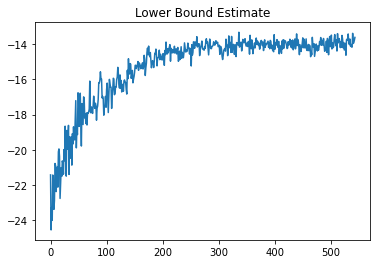

In [117]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<AxesSubplot:title={'center':'Smoothed Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

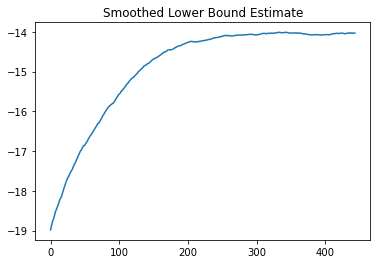

In [118]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [119]:
np.savetxt('vb_lb_varobust.txt', LB_estimate)

In [161]:
best_mu = best_lambda[0]
best_vech_l = list(best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (np.exp(best_theta_tilde[:,1]) - 1) / (np.exp(best_theta_tilde[:,1]) + 1)
best_gamma = np.exp(best_theta_tilde[:,2])
best_delta = best_theta_tilde[:,3]
best_theta = np.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([ 1.44343231,  0.06284745,  0.83434215, -0.09529927])

In [131]:
best_mu_untransformed = best_lambda_untransformed[0]
best_vech_l_untransformed = list(best_lambda_untransformed[1])
best_l_untransformed = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l_untransformed[i:num_coeffs,i] = best_vech_l_untransformed[:num_coeffs - i]
    del best_vech_l_untransformed[:num_coeffs-i]
best_Sigma_untransformed =  np.linalg.inv(best_l_untransformed @ best_l_untransformed.T)

best_theta_tilde_untransformed = multivariate_normal.rvs(mean = best_mu_untransformed, cov = best_Sigma_untransformed, size = 1000)
best_alpha_untransformed = (2 * np.exp(best_theta_tilde_untransformed[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde_untransformed[:,0]))
best_beta_untransformed = (np.exp(best_theta_tilde_untransformed[:,1]) - 1) / (np.exp(best_theta_tilde_untransformed[:,1]) + 1)
best_gamma_untransformed = np.exp(best_theta_tilde_untransformed[:,2])
best_delta_untransformed = best_theta_tilde_untransformed[:,3]
best_theta_untransformed = np.array([best_alpha_untransformed, best_beta_untransformed, best_gamma_untransformed, best_delta_untransformed])
posterior_mean_estimate_untransformed = np.mean(best_theta_untransformed, axis = 1)
posterior_mean_estimate_untransformed

array([ 1.35890551,  0.2129343 ,  0.82006315, -0.17821265])

In [142]:
best_mu_wass = best_lambda_wass[0]
best_vech_l_wass = list(best_lambda_wass[1])
best_l_wass = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l_wass[i:num_coeffs,i] = best_vech_l_wass[:num_coeffs - i]
    del best_vech_l_wass[:num_coeffs-i]
best_Sigma_wass =  np.linalg.inv(best_l_wass @ best_l_wass.T)

best_theta_tilde_wass = multivariate_normal.rvs(mean = best_mu_wass, cov = best_Sigma_wass, size = 1000)
best_alpha_wass = (2 * np.exp(best_theta_tilde_wass[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde_wass[:,0]))
best_beta_wass = (np.exp(best_theta_tilde_wass[:,1]) - 1) / (np.exp(best_theta_tilde_wass[:,1]) + 1)
best_gamma_wass = np.exp(best_theta_tilde_wass[:,2])
best_delta_wass = best_theta_tilde_wass[:,3]
best_theta_wass = np.array([best_alpha_wass, best_beta_wass, best_gamma_wass, best_delta_wass])
posterior_mean_estimate_wass = np.mean(best_theta_wass, axis = 1)
posterior_mean_estimate_wass

array([ 1.37122564,  0.24398028,  0.81337933, -0.13422818])

Text(0.5, 1.0, 'Posterior density of alpha')

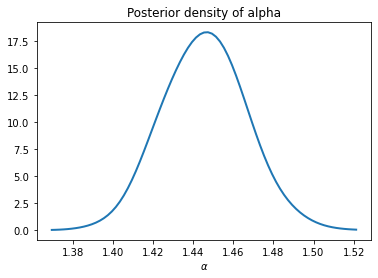

In [121]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde.fit(best_alpha.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of alpha')

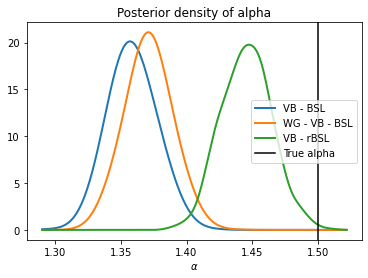

In [154]:
plt.figure()
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(np.mean(best_alpha_untransformed)-4*np.std(best_alpha_untransformed),np.mean(best_alpha)-4*np.std(best_alpha)), max(np.mean(best_alpha_untransformed)+4*np.std(best_alpha_untransformed), np.mean(best_alpha)+4*np.std(best_alpha)), 0.001)

kde_vb = KernelDensity(bandwidth=0.0055, kernel='gaussian')
kde_vb.fit(best_alpha.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb_untransformed = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde_vb_untransformed.fit(best_alpha_untransformed.reshape(-1, 1))
y_plot_vb_untransformed = kde_vb_untransformed.score_samples(x_plot.reshape(-1, 1))

kde_vb_wass = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde_vb_wass.fit(best_alpha_wass.reshape(-1, 1))
y_plot_vb_wass = kde_vb_wass.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_vb_untransformed), '-', linewidth=2.0, label = 'VB - BSL')
plt.plot(x_plot, np.exp(y_plot_vb_wass), '-', linewidth=2.0, label = 'WG - VB - BSL')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')
# only one line may be specified; full height
plt.axvline(x = 1.5, ymin = 0, ymax = max(y_plot_vb_untransformed), color = 'black', label = 'True alpha')

plt.legend()
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')


Text(0.5, 1.0, 'Posterior density of beta')

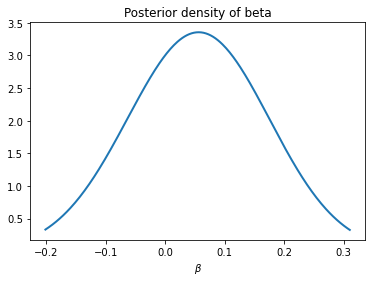

In [122]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.002)
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(best_beta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of beta')

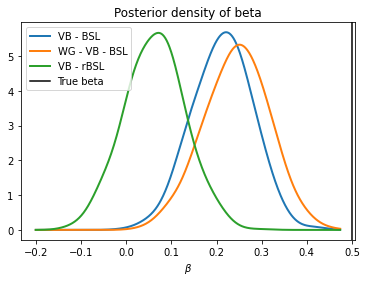

In [165]:
plt.figure()
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(np.mean(best_beta_untransformed)-4*np.std(best_beta_untransformed),np.mean(best_beta)-4*np.std(best_beta)), max(np.mean(best_beta_untransformed)+4*np.std(best_beta_untransformed), np.mean(best_beta)+4*np.std(best_beta)), 0.001)

kde_vb = KernelDensity(bandwidth=0.0255, kernel='gaussian')
kde_vb.fit(best_beta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb_untransformed = KernelDensity(bandwidth=0.0255, kernel='gaussian')
kde_vb_untransformed.fit(best_beta_untransformed.reshape(-1, 1))
y_plot_vb_untransformed = kde_vb_untransformed.score_samples(x_plot.reshape(-1, 1))

kde_vb_wass = KernelDensity(bandwidth=0.025, kernel='gaussian')
kde_vb_wass.fit(best_beta_wass.reshape(-1, 1))
y_plot_vb_wass = kde_vb_wass.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_vb_untransformed), '-', linewidth=2.0, label = 'VB - BSL')
plt.plot(x_plot, np.exp(y_plot_vb_wass), '-', linewidth=2.0, label = 'WG - VB - BSL')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')
# only one line may be specified; full height
plt.axvline(x = 0.5, ymin = 0, ymax = max(y_plot_vb_untransformed), color = 'black', label = 'True beta')

plt.legend()
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of gamma')

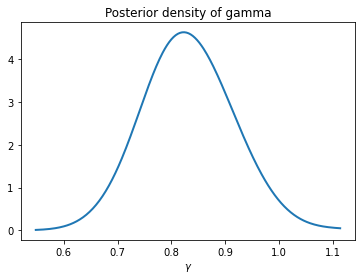

In [123]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.002)
kde = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde.fit(best_gamma.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

Text(0.5, 1.0, 'Posterior density of gamma')

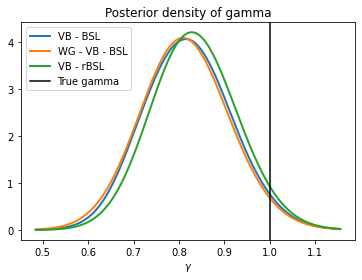

In [174]:
plt.figure()
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(np.mean(best_gamma_untransformed)-4*np.std(best_gamma_untransformed),np.mean(best_gamma)-4*np.std(best_gamma)), max(np.mean(best_gamma_untransformed)+4*np.std(best_gamma_untransformed), np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)

kde_vb = KernelDensity(bandwidth=0.0665, kernel='gaussian')
kde_vb.fit(best_gamma.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb_untransformed = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde_vb_untransformed.fit(best_gamma_untransformed.reshape(-1, 1))
y_plot_vb_untransformed = kde_vb_untransformed.score_samples(x_plot.reshape(-1, 1))

kde_vb_wass = KernelDensity(bandwidth=0.0755, kernel='gaussian')
kde_vb_wass.fit(best_gamma_wass.reshape(-1, 1))
y_plot_vb_wass = kde_vb_wass.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_vb_untransformed), '-', linewidth=2.0, label = 'VB - BSL')
plt.plot(x_plot, np.exp(y_plot_vb_wass), '-', linewidth=2.0, label = 'WG - VB - BSL')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')
# only one line may be specified; full height
plt.axvline(x = 1, ymin = 0, ymax = max(y_plot_vb_untransformed), color = 'black', label = 'True gamma')

plt.legend()
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

Text(0.5, 1.0, 'Posterior density of delta')

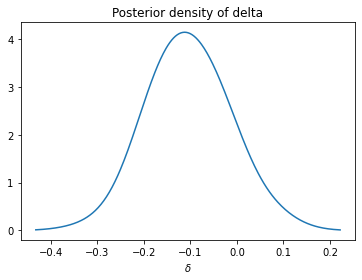

In [124]:
plt.figure()
x_plot = np.arange((np.mean(best_delta)-4*np.std(best_delta)), (np.mean(best_delta)+4*np.std(best_delta)), 0.002)
kde = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde.fit(best_delta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=1.5)
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')

Text(0.5, 1.0, 'Posterior density of delta')

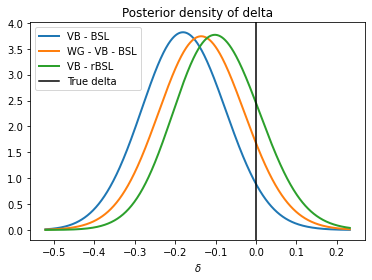

In [175]:
plt.figure()
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(np.mean(best_delta_untransformed)-4*np.std(best_delta_untransformed),np.mean(best_delta)-4*np.std(best_delta)), max(np.mean(best_delta_untransformed)+4*np.std(best_delta_untransformed), np.mean(best_delta)+4*np.std(best_delta)), 0.001)

kde_vb = KernelDensity(bandwidth=0.0665, kernel='gaussian')
kde_vb.fit(best_delta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb_untransformed = KernelDensity(bandwidth=0.06, kernel='gaussian')
kde_vb_untransformed.fit(best_delta_untransformed.reshape(-1, 1))
y_plot_vb_untransformed = kde_vb_untransformed.score_samples(x_plot.reshape(-1, 1))

kde_vb_wass = KernelDensity(bandwidth=0.0755, kernel='gaussian')
kde_vb_wass.fit(best_delta_wass.reshape(-1, 1))
y_plot_vb_wass = kde_vb_wass.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_vb_untransformed), '-', linewidth=2.0, label = 'VB - BSL')
plt.plot(x_plot, np.exp(y_plot_vb_wass), '-', linewidth=2.0, label = 'WG - VB - BSL')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')
# only one line may be specified; full height
plt.axvline(x = 0, ymin = 0, ymax = max(y_plot_vb_untransformed), color = 'black', label = 'True delta')

plt.legend()
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')

## RUN MCMC WITH ADAPTIVE RANDOM WALK

In [125]:
num_samples = 50000
num_burnin = 0.2 * num_samples

In [126]:
def sampler(samples):

	# ------------------- initialize MCMC

	w_size = num_coeffs  # num of weights and bias

	pos_w = np.ones((samples, w_size))  # posterior of all weights and bias over all samples
	pos_w_tilde = np.ones((samples, w_size))

	w_tilde = np.array([np.log((1.5-1.1)/(2-1.5)),np.log((0.5+1)/(1-0.5)),np.log(1),0])
	# w_tilde = [np.log((actual_summary_statistics[0]-1.1)/(2-actual_summary_statistics[0])), np.log((1+actual_summary_statistics[1])/(1-actual_summary_statistics[1])), np.log(actual_summary_statistics[2]), actual_summary_statistics[3]]

	alpha = (2 * np.exp(w_tilde[0]) + 1.1) / (1 + np.exp(w_tilde[0]))
	beta = (np.exp(w_tilde[1]) - 1) / (np.exp(w_tilde[1]) + 1)
	gamma = np.exp(w_tilde[2])
	delta = w_tilde[3]
	w = np.array([alpha, beta, gamma, delta])

	# GENERATE GAMMA
	Gamma_init = np.random.exponential(scale = 0.5, size = (gamma_samples, num_latent))
	adjusted_w = np.concatenate((np.tile(w, (gamma_samples, 1)), Gamma_init), axis = 1)
	# --------------------- 

	prior_current = prior(w_tilde)  # takes care of the gradients

	likelihood_current = variance_adjustment_unbiased_log_likelihood(adjusted_w)

	naccept = 0
		
	for i in range(samples - 1):
		if i < 2000:
			w_proposal_tilde = multivariate_normal.rvs(mean = w_tilde, cov = ((0.1**2/w_size) * np.identity(w_size)))
		else:
			if i % 500 == 0:
				Sign = np.cov(pos_w_tilde[0:i, :].T)
			u_proposal = random.uniform(0, 1)
			if u_proposal < 0.05:
				w_proposal_tilde = multivariate_normal.rvs(mean = w_tilde, cov = ((0.1**2/w_size) * np.identity(w_size)))
			else:
				w_proposal_tilde = multivariate_normal.rvs(mean = w_tilde, cov = (2.38**2/w_size) * Sign)

		alpha_prop = (2 * np.exp(w_proposal_tilde[0]) + 1.1) / (1 + np.exp(w_proposal_tilde[0]))
		beta_prop = (np.exp(w_proposal_tilde[1]) - 1) / (np.exp(w_proposal_tilde[1]) + 1)
		gamma_prop = np.exp(w_proposal_tilde[2])
		delta_prop = w_proposal_tilde[3]
		w_proposal = np.array([alpha_prop, beta_prop, gamma_prop, delta_prop])

		# GENERATE GAMMA
		Gamma = np.random.exponential(scale = 0.5, size = (gamma_samples, num_latent))
		adjusted_w_proposal = np.concatenate((np.tile(w_proposal, (gamma_samples, 1)), Gamma), axis = 1)
		# --------------------- 

		prior_proposal = prior(w_proposal_tilde)  # takes care of the gradients
		likelihood_proposal = variance_adjustment_unbiased_log_likelihood(adjusted_w_proposal)

		diff_prior = prior_proposal - prior_current

		diff_likelihood = likelihood_proposal - likelihood_current

		try:
			mh_prob = min(1, math.exp(diff_likelihood+diff_prior))

		except OverflowError as e:
			mh_prob = 1


		u = random.uniform(0, 1)

		if u < mh_prob:
			# Update position 
			naccept += 1
			likelihood_current = likelihood_proposal
			prior_current = prior_proposal
			w_tilde = w_proposal_tilde
			w = w_proposal
			pos_w_tilde[i + 1,] = w_proposal_tilde	
			pos_w[i + 1,] = w_proposal
			print(i, pos_w[i + 1,])

		else:
			pos_w_tilde[i + 1,] = pos_w_tilde[i,]
			pos_w[i + 1,] = pos_w[i,]

	print(naccept, ' num accepted')
	print(naccept / (samples * 1.0) * 100, '% was accepted')
	accept_ratio = naccept / (samples * 1.0) * 100

	return (pos_w, pos_w_tilde, accept_ratio)

In [127]:
pos_w, pos_w_tilde, accept_ratio = sampler(num_samples)

NameError: name 'prior' is not defined

In [ ]:
pos_w = np.loadtxt('mcmc_w_varobust.txt')
pos_w_tilde = np.loadtxt('mcmc_w_tilde_varobust.txt')

Text(0.5, 1.0, 'Posterior density of alpha')

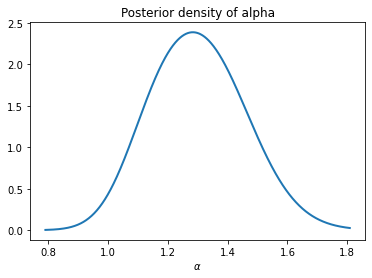

In [ ]:
plt.figure()
pos_alpha_mean = np.mean(pos_w[int(num_burnin):,0])
pos_alpha_std = np.std(pos_w[int(num_burnin):,0])
x_plot = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.001)
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(pos_w[int(num_burnin):,0].reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of alpha')

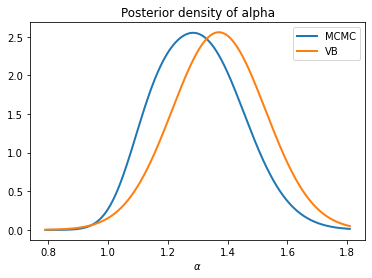

In [ ]:
plt.figure()
pos_alpha_mean = np.mean(pos_w[int(num_burnin):,0])
pos_alpha_std = np.std(pos_w[int(num_burnin):,0])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_alpha_mean-4*pos_alpha_std,np.mean(best_alpha)-4*np.std(best_alpha)), max(pos_alpha_mean+4*pos_alpha_std, np.mean(best_alpha)+4*np.std(best_alpha)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.075, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,0].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.155, kernel='gaussian')
kde_vb.fit(best_alpha.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

plt.legend()
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')


Text(0.5, 1.0, 'Posterior density of beta')

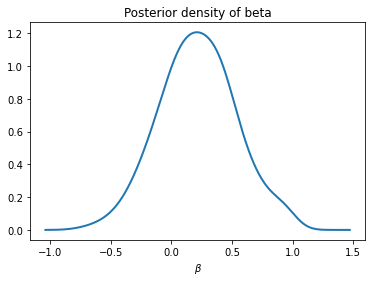

In [ ]:
plt.figure()

pos_beta_mean = np.mean(pos_w[int(num_burnin):,1])
pos_beta_std = np.std(pos_w[int(num_burnin):,1])
x_plot = np.arange((pos_beta_mean-4*pos_beta_std), (pos_beta_mean+4*pos_beta_std), 0.001)
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(pos_w[int(num_burnin):,1].reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of beta')

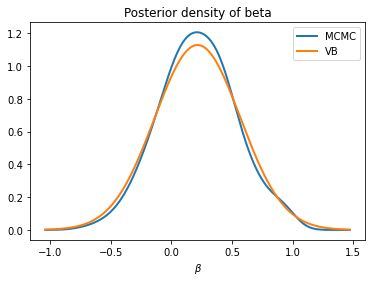

In [ ]:
plt.figure()
pos_beta_mean = np.mean(pos_w[int(num_burnin):,1])
pos_beta_std = np.std(pos_w[int(num_burnin):,1])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_beta_mean-4*pos_beta_std,np.mean(best_beta)-4*np.std(best_beta)), max(pos_beta_mean+4*pos_beta_std, np.mean(best_beta)+4*np.std(best_beta)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,1].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.35, kernel='gaussian')
kde_vb.fit(best_beta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

plt.legend()
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')


Text(0.5, 1.0, 'Posterior density of gamma')

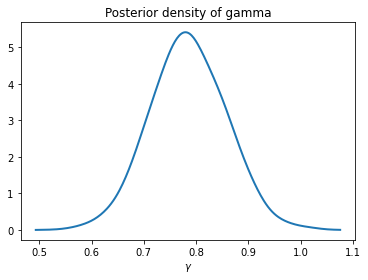

In [ ]:
plt.figure()

pos_gamma_mean = np.mean(pos_w[int(num_burnin):,2])
pos_gamma_std = np.std(pos_w[int(num_burnin):,2])
x_plot = np.arange((pos_gamma_mean-4*pos_gamma_std), (pos_gamma_mean+4*pos_gamma_std), 0.002)
kde = KernelDensity(bandwidth=0.02, kernel='gaussian')
kde.fit(pos_w[int(num_burnin):,2].reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

Text(0.5, 1.0, 'Posterior density of gamma')

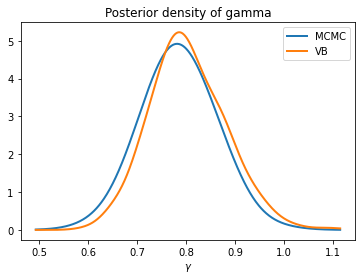

In [ ]:
plt.figure()
pos_gamma_mean = np.mean(pos_w[int(num_burnin):,2])
pos_gamma_std = np.std(pos_w[int(num_burnin):,2])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_gamma_mean-4*pos_gamma_std,np.mean(best_gamma)-4*np.std(best_gamma)), max(pos_gamma_mean+4*pos_gamma_std, np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.0375, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,2].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.025, kernel='gaussian')
kde_vb.fit(best_gamma.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

plt.legend()
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')


Text(0.5, 1.0, 'Posterior density of delta')

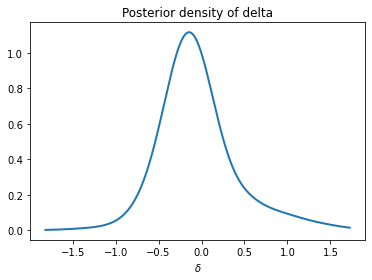

In [ ]:
plt.figure()

pos_delta_mean = np.mean(pos_w[int(num_burnin):,3])
pos_delta_std = np.std(pos_w[int(num_burnin):,3])
x_plot = np.arange((pos_delta_mean-4*pos_delta_std), (pos_delta_mean+4*pos_delta_std), 0.002)
kde = KernelDensity(bandwidth=0.2, kernel='gaussian')
kde.fit(pos_w[int(num_burnin):,3].reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')

Text(0.5, 1.0, 'Posterior density of delta')

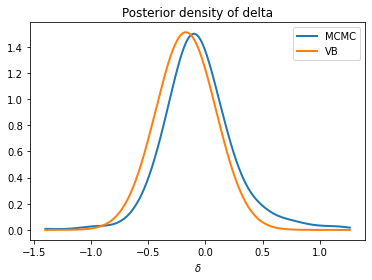

In [ ]:
plt.figure()
pos_delta_mean = np.mean(pos_w[int(num_burnin):,3])
pos_delta_std = np.std(pos_w[int(num_burnin):,3])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_delta_mean-4*pos_delta_std,np.mean(best_delta)-4*np.std(best_delta)), max(pos_delta_mean+4*pos_delta_std, np.mean(best_delta)+4*np.std(best_delta)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,3].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.25, kernel='gaussian')
kde_vb.fit(best_delta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

plt.legend()
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')


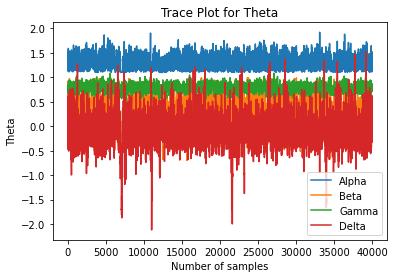

In [ ]:
alpha_trace = pos_w[int(num_burnin):,0]
beta_trace = pos_w[int(num_burnin):,1]
gamma_trace = pos_w[int(num_burnin):,2]
delta_trace = pos_w[int(num_burnin):,3]

x = np.arange(len(alpha_trace))
plt.figure(facecolor = 'white')
plt.plot(x, alpha_trace, label='Alpha')  
plt.plot(x, beta_trace, label='Beta')  
plt.plot(x, gamma_trace, label='Gamma')  
plt.plot(x, delta_trace, label='Delta')  
plt.xlabel('Number of samples')
plt.ylabel('Theta')
plt.legend()
plt.title("Trace Plot for Theta")
plt.show()